# Imports and setup

In [1]:
# We can now load the dependencies
%matplotlib inline 
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt 
import torchvision
from tqdm import tqdm
import torch.optim as optim
import torchmetrics
import pandas as pd

# If VSCode doesn't pick up this import, see answer here: 
# https://stackoverflow.com/questions/65252074/import-path-to-own-script-could-not-be-resolved-pylance-reportmissingimports
import sys
sys.path.append("../../Datasets/")
from Custom_Dataset import * 

We can start by setting a seed for reproducibility

In [2]:
torch.manual_seed(0)

# Pre-processing

We start by defining a custom dataset which loads the data from disk lazily. This is because we have too many training examples to keep all of them in memory at once. The CustomDataset class is defined in Datasets/Cutsom_Dataset.py

In [3]:
# Extract the generated data
train_gen_dataset = CustomDataset("Generated", "train", balance = True)
val_gen_dataset = CustomDataset("Generated", "validation", balance=True)
test_gen_dataset = CustomDataset("Generated", "test", balance=True)

# Extract the real data
train_real_dataset = CustomDataset("Real Life", "train", balance=True)
val_real_dataset = CustomDataset("Real Life", "validation", balance=True)
test_real_dataset = CustomDataset("Real Life", "test", balance=True)

# Hyperparameter choices

We create a cell to hold the hyperparameters of the model to tune.

In [4]:
batch_size_choices = {100, 200} # Each the real and generated data will be split into batches of this size (Since we only train on generated here)
dropout_rate_choices = {0.2, 0.5}
gamma_focal_loss_choices = {2, 5} # Choices for the gamma parameter in the focal loss
learning_rate = 0.001
n_validation = 10 # Number of iterations between each validation run
n_validation_minibatches = 2 # Number of minibatches to use for validation
n_final_validation_minibatches = 20 # Number of minibatches to use for the final validation run
num_epochs = 1 # Since we only train on generated data, we can use a small number of epochs because we have around 300000 images plus the augmentation

# Model implementation

We can start by loading a pre-trained VGG16 model without the classification layers towards the end (Only the feature extractor).

In [5]:
vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

We can now visualize its layers:

In [6]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Because we are looking for a pre-trained feature extractor here, we decide to only use the features part and freeze its weights. We can then add a few subsequent layers to fine tune predictions. We can thus define the following model:

In [7]:
class BaseModel(nn.Module):

    def __init__(self, num_classes=13, dropout_rate=0.5):
        
        super(BaseModel, self).__init__()
        
        # Define the layers of the model
        self.features = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1').features
        self.classifier = nn.Sequential(
            nn.Linear(4608, 1024),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

        # Set the features to not require gradients
        for param in self.features.parameters():
            param.requires_grad = False


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Training

We can start by finding the device to use for training:

In [8]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.has_mps:
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

if DEVICE == "cuda":
    torch.cuda.empty_cache()

print("Device:", DEVICE)

Device: mps


We can then go ahead and define the loss function we will be using. Because we will opt for a balanced focal loss instead of a regular cross entropy loss which gives more importance to the classes that are harder to classify. We thus implement the focal loss defined by the following formula:
$$
FL(p_t) = -(1-p_t^{\gamma})log(p_t)
$$

where gamma $\gamma$ is a tunable hyperparameter. We can also further add an alpha term to handle class imbalance, making our loss function a class-balanced focal loss, as shown in https://github.com/AdeelH/pytorch-multi-class-focal-loss. 
Note: Since we have balanced classes thanks to oversmapling, we will not use the alpha parameter.



Finally, we need an accuracy metric to tune the hyperparameters of the model. We will opt for a balanced accuracy score, which is just regular classification accuracy but adapted to weigh each class by its frequency:

In [9]:
# Define the accuracy metrics
f1_score = torchmetrics.F1Score(task="multiclass", num_classes=13, average="weighted").to(DEVICE)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=13, average="weighted").to(DEVICE)

We can now load a single example from the loader and display its label as well as its class proportion, which should be around 1/13 which is +- 8%.

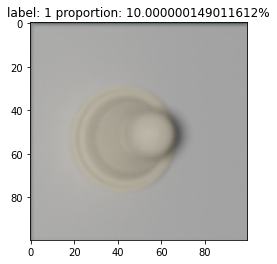

In [10]:
gen_train_loader = get_loader(train_gen_dataset, batch_size=200)

for i, (images, labels) in enumerate(gen_train_loader):
    class_proportions = [(labels == i).sum() / len(labels) for i in range(13)]
    plt.title("label: " + str(labels[0].item()) + " proportion: " + str(class_proportions[labels[0].item()].item() * 100) + "%")
    plt.imshow(images[0].permute(1, 2, 0))
    break

We can also define the following function for plotting the metrics collected during training:

In [11]:
def plot_and_save_metrics(gen_training_losses, gen_training_accs, gen_training_f1s, gen_validation_losses, gen_validation_accs, gen_validation_f1s, real_validation_losses, real_validation_accs, real_validation_f1s, gamma, batch_size, dropout_rate):

    validation_x_axis = np.arange(0, len(gen_validation_losses) * n_validation, n_validation)

    plt.figure(figsize=(30, 30))

    plt.subplot(3, 2, 1)
    plt.plot(gen_training_losses)
    plt.title("Training Losses")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")

    plt.subplot(3, 2, 2)
    plt.plot(gen_training_accs)
    plt.title("Training Accuracies")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")

    plt.subplot(3, 2, 3)
    plt.plot(gen_training_f1s)
    plt.title("Training weighted F1 scores")
    plt.xlabel("Iteration")
    plt.ylabel("Weighted F1 score")

    plt.subplot(3, 2, 4)
    plt.plot(validation_x_axis, gen_validation_losses, label="Source domain")
    plt.plot(validation_x_axis, real_validation_losses, label="Target domain")
    plt.title("Validation Losses")
    plt.xlabel("Iteration")
    plt.ylabel("Focal loss")
    plt.legend()

    plt.subplot(3, 2, 5)
    plt.plot(validation_x_axis, gen_validation_accs, label="Source domain")
    plt.plot(validation_x_axis, real_validation_accs, label="Target domain")
    plt.title("Validation Accuracies")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(3, 2, 6)
    plt.plot(validation_x_axis, gen_validation_f1s, label="Source domain")
    plt.plot(validation_x_axis, real_validation_f1s, label="Target domain")
    plt.title("Validation weighted F1 Scores")
    plt.xlabel("Iteration")
    plt.ylabel("Weighted F1 Score")
    plt.legend()

    plt.suptitle("Hyperparameters: gamma: " + str(gamma) + ", batch_size: " + str(batch_size) + ", dropout_rate: " + str(dropout_rate), fontsize=24)
    
    plt.savefig("HP tuning results/" + "gamma_" + str(gamma) + "_batch_" + str(batch_size) + "_dropout_" + str(dropout_rate) + ".png",  facecolor='white', transparent=False)
    plt.close()

We can now define a training function we will call for each hyperparameter combination.

In [12]:
def train_BASE(gamma, dropout_rate, batch_size):
    # Define the data loaders accounting for the batch size
    train_loader = get_gen_loader(train_gen_dataset, batch_size=batch_size)
    gen_val_loader = get_gen_loader(val_gen_dataset, batch_size=batch_size)
    real_val_loader = get_real_loader(val_real_dataset, batch_size=batch_size)  

    # Define the new loss function (Taking into account gamma)
    focal_loss = torch.hub.load(
        'adeelh/pytorch-multi-class-focal-loss',
        model='FocalLoss',
        gamma=gamma, # No use of alpha since we have balanced classes now with the oversampling
        reduction='mean',
        force_reload=False,
        verbose = False
    ).to(DEVICE)

    basemodel = BaseModel(dropout_rate=dropout_rate).to(DEVICE)      
    opt = optim.Adam(basemodel.parameters(), lr=learning_rate)

    # To store the metrics through epochs
    gen_training_losses = []
    gen_training_accs = []
    gen_training_f1s = []
    gen_validation_losses = []
    gen_validation_accs = []
    gen_validation_f1s = []
    real_validation_losses = []
    real_validation_accs = []
    real_validation_f1s = []

    for epoch in range(num_epochs):
        
        # Train the model
        for iteration, (X_train_gen, y_train_gen) in tqdm(enumerate(train_loader)):
            
            # Set the model to training mode
            basemodel.train()

            # Move the data to the device
            X_train_gen = X_train_gen.to(DEVICE)
            y_train_gen = y_train_gen.to(DEVICE)

            # Forward pass
            y_train_pred_raw_gen = basemodel(X_train_gen)
            y_train_pred_gen = torch.argmax(y_train_pred_raw_gen, dim=1)

            # Compute the loss
            loss_train = focal_loss(y_train_pred_raw_gen, y_train_gen.long())

            # Compute the accuracy
            acc_train = accuracy(y_train_pred_gen, y_train_gen)
            f1_train = f1_score(y_train_pred_gen, y_train_gen)

            # Backward pass
            opt.zero_grad()
            loss_train.backward()
            opt.step()

            # Store the loss & accuracy
            gen_training_losses.append(loss_train.item())
            gen_training_accs.append(acc_train.item())
            gen_training_f1s.append(f1_train.item())
            
            # Check if the model should be validated
            if iteration == 0 or (iteration + 1) % n_validation == 0:
                
                # Set the model to evaluation mode
                basemodel.eval()
                
                # Disable gradient calculation
                with torch.no_grad():

                    # 1) Evaluate on the generated validation set
                    acc_val_sum = 0
                    weighted_f1_val_sum = 0
                    loss_val_sum = 0

                    # Extract an iterator from the generated data loader
                    gen_val_iter = iter(gen_val_loader)

                    # Iterate for n_validation_minibatches
                    for i in range(n_validation_minibatches):

                        # Get the next minibatch
                        X_val_gen, y_val_gen = next(gen_val_iter)
                            
                        # Move the data to the device
                        X_val_gen = X_val_gen.to(DEVICE)
                        y_val_gen = y_val_gen.to(DEVICE)

                        # Forward pass
                        y_val_pred_raw_gen = basemodel(X_val_gen)
                        y_val_pred_gen = torch.argmax(y_val_pred_raw_gen, dim=1)

                        # Compute the metrics
                        acc_val_sum += accuracy(y_val_pred_gen, y_val_gen)
                        weighted_f1_val_sum += f1_score(y_val_pred_gen, y_val_gen)
                        loss_val_sum += focal_loss(y_val_pred_raw_gen, y_val_gen)

                    # Compute the average metrics
                    acc_val_gen = acc_val_sum / n_validation_minibatches
                    loss_val_gen = loss_val_sum / n_validation_minibatches
                    weighted_f1_val_gen = weighted_f1_val_sum / n_validation_minibatches

                    # 2) Repeat on the real validation set
                    acc_val_sum = 0
                    weighted_f1_val_sum = 0
                    loss_val_sum = 0

                    # Extract an iterator from the generated data loader
                    real_val_iter = iter(real_val_loader)

                    # Iterate for n_validation_minibatches
                    for i in range(n_validation_minibatches):

                        # Get the next minibatch
                        X_val_real, y_val_real = next(real_val_iter)
                            
                        # Move the data to the device
                        X_val_real = X_val_real.to(DEVICE)
                        y_val_real = y_val_real.to(DEVICE)

                        # Forward pass
                        y_val_pred_raw_real = basemodel(X_val_real)
                        y_val_pred_real = torch.argmax(y_val_pred_raw_real, dim=1)

                        # Compute the metrics
                        acc_val_sum += accuracy(y_val_pred_real, y_val_real)
                        weighted_f1_val_sum += f1_score(y_val_pred_real, y_val_real)
                        loss_val_sum += focal_loss(y_val_pred_raw_real, y_val_real)

                    # Compute the average metrics
                    acc_val_real = acc_val_sum / n_validation_minibatches
                    loss_val_real = loss_val_sum / n_validation_minibatches
                    weighted_f1_val_real = weighted_f1_val_sum / n_validation_minibatches

                    # Store all 6 metrics
                    gen_validation_losses.append(loss_val_gen.item())
                    gen_validation_accs.append(acc_val_gen.item())
                    gen_validation_f1s.append(weighted_f1_val_gen.item())
                    real_validation_losses.append(loss_val_real.item())
                    real_validation_accs.append(acc_val_real.item())
                    real_validation_f1s.append(weighted_f1_val_real.item())

                    # Print an update
                    print('----------------------------------------------------------------')
                    print(f'EPOCH [{epoch + 1}], ITERATION [{iteration+1}]')
                    print(f'TRAINING => Loss: {loss_train}, Training accuracy: {acc_train}, Training weighted F1: {f1_train}')
                    print(f'GENERATED VALIDATION => Loss: {loss_val_gen}, Validation accuracy: {acc_val_gen}, Validation weighted F1: {weighted_f1_val_gen}')
                    print(f'REAL VALIDATION => Loss: {loss_val_real}, Validation accuracy: {acc_val_real}, Validation weighted F1: {weighted_f1_val_real}')
                    print('----------------------------------------------------------------')

        # Save the model every epoch as a checkpoint 
        torch.save(basemodel.state_dict(), f'./checkpoints/basemodel_gamma_{gamma}_dropout_{dropout_rate}_batch_{batch_size}_epoch_{epoch+1}.ckpt')
    
    # Plot and save the metrics
    plot_and_save_metrics(gen_training_losses, gen_training_accs, gen_training_f1s, gen_validation_losses, gen_validation_accs, gen_validation_f1s, real_validation_losses, real_validation_accs, real_validation_f1s, gamma, batch_size, dropout_rate)
    
    return basemodel

We also define an evaluate function to compare the best models obtained during training for each hyperparameter combination. The comparison is done on the real life validation set.

In [13]:
def evaluate(basemodel, batch_size):
    # Load the real validation dataset
    real_val_loader = get_real_loader(val_real_dataset, batch_size=batch_size)  

    # Evaluate the final real life validation accuracy
    # Set the model to evaluation mode
    basemodel.eval()
    acc_val_sum = 0

    # Create an iterator
    real_val_iter = iter(real_val_loader)

    # Disable gradient calculation
    with torch.no_grad():
        
        for i in range(n_final_validation_minibatches):

            # Get the next minibatch
            minibatch = next(real_val_iter, None)
            if minibatch is None:
                real_val_iter = iter(real_val_loader)
                minibatch = next(real_val_iter, None)
            X_val_real, y_val_real = minibatch

            # Move the data to the device
            X_val_real = X_val_real.to(DEVICE)
            y_val_real = y_val_real.to(DEVICE)

            # Forward pass
            y_val_pred_prob_real = basemodel(X_val_real)
            y_val_pred_real = torch.argmax(y_val_pred_prob_real, dim=1)

            # Compute the metrics
            acc_val_sum += accuracy(y_val_pred_real, y_val_real)

    # Compute the average accuracy
    final_real_val_acc = acc_val_sum / n_final_validation_minibatches

    return final_real_val_acc

We can now proceed to train our model on the generated dataset:

In [15]:
# To store the best model
best_model = None
best_acc = -1

# Store the validation accuracies
hp_final_accs = pd.DataFrame(columns=["Gamma", "Dropout Rate", "Batch Size", "Final validation accuracy"])

for gamma in gamma_focal_loss_choices:

    for dropout_rate in dropout_rate_choices:

        for batch_size in batch_size_choices:
            
            # Train the model
            basemodel = train_BASE(gamma, dropout_rate, batch_size)

            # Evaluate the model on the real validation set 
            final_real_val_acc = evaluate(basemodel, batch_size)  

            # Create a row to add to the dataframe
            row = [gamma, batch_size, dropout_rate, final_real_val_acc.cpu().item()]
            
            # Store it
            hp_final_accs.loc[len(hp_final_accs)] = row

            # Compare to the best model
            if best_model is None or best_acc < final_real_val_acc:
                best_model = basemodel
                best_acc = final_real_val_acc
                torch.save(basemodel.state_dict(), f'./best_model.ckpt')

# Save the dataframe as a table
hp_final_accs.to_csv('HP_final_accuracies.csv', index=False)    

0it [00:00, ?it/s]/Users/enzobenoit-jeannin/Documents/GitHub/RecogniChess/myenv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
2it [00:01,  1.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1]
TRAINING => Loss: 2.1881399154663086, Training accuracy: 0.10999999940395355, Training weighted F1: 0.05301010236144066
GENERATED VALIDATION => Loss: 2.065793991088867, Validation accuracy: 0.23499999940395355, Validation weighted F1: 0.15793533623218536
REAL VALIDATION => Loss: 2.1193015575408936, Validation accuracy: 0.14000000059604645, Validation weighted F1: 0.11085361242294312
----------------------------------------------------------------


11it [00:03,  2.77it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [10]
TRAINING => Loss: 0.8817280530929565, Training accuracy: 0.5900000333786011, Training weighted F1: 0.5159664750099182
GENERATED VALIDATION => Loss: 0.6519197225570679, Validation accuracy: 0.6449999809265137, Validation weighted F1: 0.61002516746521
REAL VALIDATION => Loss: 1.5214356184005737, Validation accuracy: 0.3100000023841858, Validation weighted F1: 0.2476906180381775
----------------------------------------------------------------


21it [00:06,  2.83it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [20]
TRAINING => Loss: 0.34091460704803467, Training accuracy: 0.7200000286102295, Training weighted F1: 0.6990957856178284
GENERATED VALIDATION => Loss: 0.22797605395317078, Validation accuracy: 0.8399999737739563, Validation weighted F1: 0.835224986076355
REAL VALIDATION => Loss: 1.4479928016662598, Validation accuracy: 0.4649999737739563, Validation weighted F1: 0.42782631516456604
----------------------------------------------------------------


31it [00:08,  2.84it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [30]
TRAINING => Loss: 0.19632865488529205, Training accuracy: 0.7900000214576721, Training weighted F1: 0.7903186082839966
GENERATED VALIDATION => Loss: 0.16510939598083496, Validation accuracy: 0.8799999952316284, Validation weighted F1: 0.8815100789070129
REAL VALIDATION => Loss: 1.8322430849075317, Validation accuracy: 0.42000001668930054, Validation weighted F1: 0.3898151218891144
----------------------------------------------------------------


41it [00:11,  2.85it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [40]
TRAINING => Loss: 0.10745656490325928, Training accuracy: 0.8799999952316284, Training weighted F1: 0.8755376935005188
GENERATED VALIDATION => Loss: 0.09891031682491302, Validation accuracy: 0.9099999666213989, Validation weighted F1: 0.9143160581588745
REAL VALIDATION => Loss: 2.353221893310547, Validation accuracy: 0.3799999952316284, Validation weighted F1: 0.33061444759368896
----------------------------------------------------------------


51it [00:14,  2.85it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [50]
TRAINING => Loss: 0.08955264836549759, Training accuracy: 0.8999999761581421, Training weighted F1: 0.8975993394851685
GENERATED VALIDATION => Loss: 0.060297317802906036, Validation accuracy: 0.9550000429153442, Validation weighted F1: 0.9552596211433411
REAL VALIDATION => Loss: 1.4365352392196655, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.47895437479019165
----------------------------------------------------------------


61it [00:16,  2.86it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [60]
TRAINING => Loss: 0.08726897835731506, Training accuracy: 0.9200000166893005, Training weighted F1: 0.9178672432899475
GENERATED VALIDATION => Loss: 0.10659296810626984, Validation accuracy: 0.9049999713897705, Validation weighted F1: 0.9027708172798157
REAL VALIDATION => Loss: 2.5303709506988525, Validation accuracy: 0.35499998927116394, Validation weighted F1: 0.3270215392112732
----------------------------------------------------------------


71it [00:19,  2.85it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [70]
TRAINING => Loss: 0.09406431019306183, Training accuracy: 0.9200000166893005, Training weighted F1: 0.9171185493469238
GENERATED VALIDATION => Loss: 0.03643202409148216, Validation accuracy: 0.9699999094009399, Validation weighted F1: 0.9688361883163452
REAL VALIDATION => Loss: 1.8425564765930176, Validation accuracy: 0.4650000035762787, Validation weighted F1: 0.429663747549057
----------------------------------------------------------------


81it [00:22,  2.86it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [80]
TRAINING => Loss: 0.028931792825460434, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9614285826683044
GENERATED VALIDATION => Loss: 0.061506859958171844, Validation accuracy: 0.9449999928474426, Validation weighted F1: 0.9467864036560059
REAL VALIDATION => Loss: 1.8009321689605713, Validation accuracy: 0.41499996185302734, Validation weighted F1: 0.3871762156486511
----------------------------------------------------------------


91it [00:24,  2.87it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [90]
TRAINING => Loss: 0.08169015496969223, Training accuracy: 0.8999999761581421, Training weighted F1: 0.8999323844909668
GENERATED VALIDATION => Loss: 0.09804429858922958, Validation accuracy: 0.9399999976158142, Validation weighted F1: 0.9394240379333496
REAL VALIDATION => Loss: 1.1990981101989746, Validation accuracy: 0.5450000166893005, Validation weighted F1: 0.5214429497718811
----------------------------------------------------------------


101it [00:27,  2.86it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [100]
TRAINING => Loss: 0.05302884802222252, Training accuracy: 0.9099999666213989, Training weighted F1: 0.9106127023696899
GENERATED VALIDATION => Loss: 0.037563640624284744, Validation accuracy: 0.9599999785423279, Validation weighted F1: 0.9596942067146301
REAL VALIDATION => Loss: 1.7567182779312134, Validation accuracy: 0.4150000214576721, Validation weighted F1: 0.42354416847229004
----------------------------------------------------------------


111it [00:29,  2.88it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [110]
TRAINING => Loss: 0.061828143894672394, Training accuracy: 0.940000057220459, Training weighted F1: 0.9422394633293152
GENERATED VALIDATION => Loss: 0.05094274878501892, Validation accuracy: 0.9699999690055847, Validation weighted F1: 0.9649914503097534
REAL VALIDATION => Loss: 1.403729796409607, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.46498680114746094
----------------------------------------------------------------


121it [00:32,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [120]
TRAINING => Loss: 0.055313561111688614, Training accuracy: 0.9699999690055847, Training weighted F1: 0.967455267906189
GENERATED VALIDATION => Loss: 0.044368285685777664, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.979856550693512
REAL VALIDATION => Loss: 1.1941123008728027, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5079891681671143
----------------------------------------------------------------


131it [00:35,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [130]
TRAINING => Loss: 0.023996533825993538, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9723682403564453
GENERATED VALIDATION => Loss: 0.01550899725407362, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.979655921459198
REAL VALIDATION => Loss: 1.999542236328125, Validation accuracy: 0.4300000071525574, Validation weighted F1: 0.41480085253715515
----------------------------------------------------------------


141it [00:37,  2.88it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [140]
TRAINING => Loss: 0.01929466612637043, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900000095367432
GENERATED VALIDATION => Loss: 0.0388614684343338, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9657764434814453
REAL VALIDATION => Loss: 1.9767987728118896, Validation accuracy: 0.46000000834465027, Validation weighted F1: 0.45108187198638916
----------------------------------------------------------------


151it [00:40,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [150]
TRAINING => Loss: 0.02017729915678501, Training accuracy: 0.9800000190734863, Training weighted F1: 0.979926586151123
GENERATED VALIDATION => Loss: 0.034387849271297455, Validation accuracy: 0.9500000476837158, Validation weighted F1: 0.9509924054145813
REAL VALIDATION => Loss: 1.4104881286621094, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.4885741174221039
----------------------------------------------------------------


161it [00:42,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [160]
TRAINING => Loss: 0.09003857523202896, Training accuracy: 0.9199999570846558, Training weighted F1: 0.9215004444122314
GENERATED VALIDATION => Loss: 0.0188722126185894, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899547100067139
REAL VALIDATION => Loss: 1.7035263776779175, Validation accuracy: 0.5400000214576721, Validation weighted F1: 0.5018714666366577
----------------------------------------------------------------


171it [00:45,  2.90it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [170]
TRAINING => Loss: 0.06789016723632812, Training accuracy: 0.9499999284744263, Training weighted F1: 0.9485759735107422
GENERATED VALIDATION => Loss: 0.053548701107501984, Validation accuracy: 0.9500000476837158, Validation weighted F1: 0.9496795535087585
REAL VALIDATION => Loss: 1.6089742183685303, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5004379153251648
----------------------------------------------------------------


181it [00:48,  2.90it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [180]
TRAINING => Loss: 0.05011822655797005, Training accuracy: 0.949999988079071, Training weighted F1: 0.9506601691246033
GENERATED VALIDATION => Loss: 0.05602244660258293, Validation accuracy: 0.9449999332427979, Validation weighted F1: 0.9473500847816467
REAL VALIDATION => Loss: 1.6462591886520386, Validation accuracy: 0.4699999988079071, Validation weighted F1: 0.4492753744125366
----------------------------------------------------------------


191it [00:50,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [190]
TRAINING => Loss: 0.026782168075442314, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9802547693252563
GENERATED VALIDATION => Loss: 0.031559959053993225, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9754869937896729
REAL VALIDATION => Loss: 1.5653162002563477, Validation accuracy: 0.4749999940395355, Validation weighted F1: 0.4686722159385681
----------------------------------------------------------------


201it [00:53,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [200]
TRAINING => Loss: 0.032641977071762085, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9802020788192749
GENERATED VALIDATION => Loss: 0.029990989714860916, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9749516248703003
REAL VALIDATION => Loss: 1.695931077003479, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.4580996036529541
----------------------------------------------------------------


211it [00:55,  2.90it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [210]
TRAINING => Loss: 0.020610570907592773, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9699177742004395
GENERATED VALIDATION => Loss: 0.0502522736787796, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9748227596282959
REAL VALIDATION => Loss: 1.8604927062988281, Validation accuracy: 0.48499998450279236, Validation weighted F1: 0.45145153999328613
----------------------------------------------------------------


221it [00:58,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [220]
TRAINING => Loss: 0.05547007918357849, Training accuracy: 0.940000057220459, Training weighted F1: 0.9357608556747437
GENERATED VALIDATION => Loss: 0.011489419266581535, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900956749916077
REAL VALIDATION => Loss: 1.6730101108551025, Validation accuracy: 0.5450000166893005, Validation weighted F1: 0.5134880542755127
----------------------------------------------------------------


231it [01:01,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [230]
TRAINING => Loss: 0.010775506496429443, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9900701642036438
GENERATED VALIDATION => Loss: 0.011690115556120872, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9851542711257935
REAL VALIDATION => Loss: 2.046616554260254, Validation accuracy: 0.4399999678134918, Validation weighted F1: 0.39964792132377625
----------------------------------------------------------------


241it [01:03,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [240]
TRAINING => Loss: 0.05890199542045593, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9699164628982544
GENERATED VALIDATION => Loss: 0.024800779297947884, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9696769714355469
REAL VALIDATION => Loss: 1.6639764308929443, Validation accuracy: 0.5799999833106995, Validation weighted F1: 0.5489541292190552
----------------------------------------------------------------


251it [01:06,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [250]
TRAINING => Loss: 0.03971865400671959, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9803521633148193
GENERATED VALIDATION => Loss: 0.039292678236961365, Validation accuracy: 0.9649999737739563, Validation weighted F1: 0.962903618812561
REAL VALIDATION => Loss: 2.1186633110046387, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.42808622121810913
----------------------------------------------------------------


261it [01:08,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [260]
TRAINING => Loss: 0.01616661250591278, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9802542924880981
GENERATED VALIDATION => Loss: 0.016142427921295166, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848659038543701
REAL VALIDATION => Loss: 1.4453068971633911, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.4824874699115753
----------------------------------------------------------------


271it [01:11,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [270]
TRAINING => Loss: 0.08878558874130249, Training accuracy: 0.9399999976158142, Training weighted F1: 0.9386640191078186
GENERATED VALIDATION => Loss: 0.022727487608790398, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9750456809997559
REAL VALIDATION => Loss: 1.4368937015533447, Validation accuracy: 0.5449999570846558, Validation weighted F1: 0.5278315544128418
----------------------------------------------------------------


281it [01:13,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [280]
TRAINING => Loss: 0.026347681879997253, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9704920649528503
GENERATED VALIDATION => Loss: 0.00985819660127163, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900487661361694
REAL VALIDATION => Loss: 1.3706398010253906, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.49865469336509705
----------------------------------------------------------------


291it [01:16,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [290]
TRAINING => Loss: 0.015345596708357334, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9796870350837708
GENERATED VALIDATION => Loss: 0.020676739513874054, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848843216896057
REAL VALIDATION => Loss: 1.5197820663452148, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5451370477676392
----------------------------------------------------------------


301it [01:19,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [300]
TRAINING => Loss: 0.0010129063157364726, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.03753618896007538, Validation accuracy: 0.9550000429153442, Validation weighted F1: 0.9553227424621582
REAL VALIDATION => Loss: 1.536983609199524, Validation accuracy: 0.4949999749660492, Validation weighted F1: 0.4738324284553528
----------------------------------------------------------------


311it [01:21,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [310]
TRAINING => Loss: 0.027711007744073868, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9703012704849243
GENERATED VALIDATION => Loss: 0.03223371133208275, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9758303165435791
REAL VALIDATION => Loss: 1.6654800176620483, Validation accuracy: 0.48499998450279236, Validation weighted F1: 0.44734740257263184
----------------------------------------------------------------


321it [01:24,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [320]
TRAINING => Loss: 0.06239913031458855, Training accuracy: 0.949999988079071, Training weighted F1: 0.9490371942520142
GENERATED VALIDATION => Loss: 0.04386822506785393, Validation accuracy: 0.9599999785423279, Validation weighted F1: 0.958906888961792
REAL VALIDATION => Loss: 1.520806074142456, Validation accuracy: 0.4999999701976776, Validation weighted F1: 0.4639313220977783
----------------------------------------------------------------


331it [01:26,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [330]
TRAINING => Loss: 0.061826739460229874, Training accuracy: 0.949999988079071, Training weighted F1: 0.9535454511642456
GENERATED VALIDATION => Loss: 0.016786355525255203, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9901562929153442
REAL VALIDATION => Loss: 1.422800898551941, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.5029973387718201
----------------------------------------------------------------


341it [01:29,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [340]
TRAINING => Loss: 0.015293779782950878, Training accuracy: 0.9800000190734863, Training weighted F1: 0.980319082736969
GENERATED VALIDATION => Loss: 0.014711733907461166, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9800533652305603
REAL VALIDATION => Loss: 1.0414111614227295, Validation accuracy: 0.6649999618530273, Validation weighted F1: 0.6742907762527466
----------------------------------------------------------------


351it [01:31,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [350]
TRAINING => Loss: 0.031172916293144226, Training accuracy: 0.949999988079071, Training weighted F1: 0.9502896070480347
GENERATED VALIDATION => Loss: 0.012328453361988068, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9898136854171753
REAL VALIDATION => Loss: 1.2836036682128906, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5307722687721252
----------------------------------------------------------------


361it [01:34,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [360]
TRAINING => Loss: 0.04865490645170212, Training accuracy: 0.9800000786781311, Training weighted F1: 0.9799301624298096
GENERATED VALIDATION => Loss: 0.04083841294050217, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9745067358016968
REAL VALIDATION => Loss: 2.0189292430877686, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.46557584404945374
----------------------------------------------------------------


371it [01:36,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [370]
TRAINING => Loss: 0.025719158351421356, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9610006809234619
GENERATED VALIDATION => Loss: 0.014607986435294151, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850854873657227
REAL VALIDATION => Loss: 1.4067885875701904, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5183734893798828
----------------------------------------------------------------


381it [01:39,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [380]
TRAINING => Loss: 0.012050901539623737, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900309443473816
GENERATED VALIDATION => Loss: 0.026619162410497665, Validation accuracy: 0.9699999690055847, Validation weighted F1: 0.9699815511703491
REAL VALIDATION => Loss: 1.30826735496521, Validation accuracy: 0.5700000524520874, Validation weighted F1: 0.5705718994140625
----------------------------------------------------------------


391it [01:42,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [390]
TRAINING => Loss: 0.003729199757799506, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.008007021620869637, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.989939272403717
REAL VALIDATION => Loss: 1.2258907556533813, Validation accuracy: 0.559999942779541, Validation weighted F1: 0.560575008392334
----------------------------------------------------------------


401it [01:44,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [400]
TRAINING => Loss: 0.01702500693500042, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9803943037986755
GENERATED VALIDATION => Loss: 0.01143189799040556, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950315952301025
REAL VALIDATION => Loss: 1.5082061290740967, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.4889601171016693
----------------------------------------------------------------


411it [01:47,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [410]
TRAINING => Loss: 0.009259626269340515, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9801590442657471
GENERATED VALIDATION => Loss: 0.0337652862071991, Validation accuracy: 0.9749999642372131, Validation weighted F1: 0.9746743440628052
REAL VALIDATION => Loss: 1.4144668579101562, Validation accuracy: 0.625, Validation weighted F1: 0.6103924512863159
----------------------------------------------------------------


421it [01:49,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [420]
TRAINING => Loss: 0.02664766274392605, Training accuracy: 0.9399999976158142, Training weighted F1: 0.9391269683837891
GENERATED VALIDATION => Loss: 0.015693895518779755, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849616289138794
REAL VALIDATION => Loss: 2.079441785812378, Validation accuracy: 0.45499998331069946, Validation weighted F1: 0.42252570390701294
----------------------------------------------------------------


431it [01:52,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [430]
TRAINING => Loss: 0.009411321952939034, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9896190166473389
GENERATED VALIDATION => Loss: 0.015845436602830887, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9948692917823792
REAL VALIDATION => Loss: 1.9541974067687988, Validation accuracy: 0.38999998569488525, Validation weighted F1: 0.35435014963150024
----------------------------------------------------------------


441it [01:54,  2.95it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [440]
TRAINING => Loss: 0.014651092700660229, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9902821779251099
GENERATED VALIDATION => Loss: 0.012245641089975834, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900350570678711
REAL VALIDATION => Loss: 1.812694787979126, Validation accuracy: 0.47499996423721313, Validation weighted F1: 0.45173704624176025
----------------------------------------------------------------


451it [01:57,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [450]
TRAINING => Loss: 0.010635006241500378, Training accuracy: 0.9800000190734863, Training weighted F1: 0.980070173740387
GENERATED VALIDATION => Loss: 0.029376711696386337, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9842692613601685
REAL VALIDATION => Loss: 1.8474736213684082, Validation accuracy: 0.5449999570846558, Validation weighted F1: 0.5266361832618713
----------------------------------------------------------------


461it [01:59,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [460]
TRAINING => Loss: 0.00918908603489399, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9901214241981506
GENERATED VALIDATION => Loss: 0.024386432021856308, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9750881195068359
REAL VALIDATION => Loss: 1.8898804187774658, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.43728095293045044
----------------------------------------------------------------


471it [02:02,  2.95it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [470]
TRAINING => Loss: 0.009889962151646614, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9797980189323425
GENERATED VALIDATION => Loss: 0.01964721642434597, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850363731384277
REAL VALIDATION => Loss: 1.381843090057373, Validation accuracy: 0.5699999928474426, Validation weighted F1: 0.5810725688934326
----------------------------------------------------------------


481it [02:04,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [480]
TRAINING => Loss: 0.006927001290023327, Training accuracy: 0.9900000095367432, Training weighted F1: 0.98996901512146
GENERATED VALIDATION => Loss: 0.012205204926431179, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799197912216187
REAL VALIDATION => Loss: 1.3479877710342407, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5134239792823792
----------------------------------------------------------------


491it [02:07,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [490]
TRAINING => Loss: 0.0068869623355567455, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900310039520264
GENERATED VALIDATION => Loss: 0.012685569003224373, Validation accuracy: 0.9749999642372131, Validation weighted F1: 0.975366473197937
REAL VALIDATION => Loss: 1.7272093296051025, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5004326105117798
----------------------------------------------------------------


501it [02:10,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [500]
TRAINING => Loss: 0.00363688706420362, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.007399150636047125, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899898767471313
REAL VALIDATION => Loss: 1.6475675106048584, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5406606197357178
----------------------------------------------------------------


511it [02:12,  2.95it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [510]
TRAINING => Loss: 0.02709723822772503, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9797897934913635
GENERATED VALIDATION => Loss: 0.014677528291940689, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899672269821167
REAL VALIDATION => Loss: 1.4955470561981201, Validation accuracy: 0.5, Validation weighted F1: 0.46253839135169983
----------------------------------------------------------------


521it [02:15,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [520]
TRAINING => Loss: 0.03887488320469856, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9696933627128601
GENERATED VALIDATION => Loss: 0.01625726744532585, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9747145771980286
REAL VALIDATION => Loss: 1.822312831878662, Validation accuracy: 0.4949999749660492, Validation weighted F1: 0.4550234079360962
----------------------------------------------------------------


531it [02:17,  2.95it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [530]
TRAINING => Loss: 0.021975688636302948, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9691284894943237
GENERATED VALIDATION => Loss: 0.01854066364467144, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850121736526489
REAL VALIDATION => Loss: 1.2340970039367676, Validation accuracy: 0.5899999737739563, Validation weighted F1: 0.5578376054763794
----------------------------------------------------------------


541it [02:20,  2.95it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [540]
TRAINING => Loss: 0.04189112037420273, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9695471525192261
GENERATED VALIDATION => Loss: 0.03513526916503906, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9747511148452759
REAL VALIDATION => Loss: 1.8444960117340088, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5209510326385498
----------------------------------------------------------------


551it [02:22,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [550]
TRAINING => Loss: 0.04327235743403435, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9825847148895264
GENERATED VALIDATION => Loss: 0.040533632040023804, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9573637247085571
REAL VALIDATION => Loss: 1.9935568571090698, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.4790317416191101
----------------------------------------------------------------


561it [02:25,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [560]
TRAINING => Loss: 0.0030971739906817675, Training accuracy: 0.9999999403953552, Training weighted F1: 0.9999999403953552
GENERATED VALIDATION => Loss: 0.0208059623837471, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799861907958984
REAL VALIDATION => Loss: 1.1831387281417847, Validation accuracy: 0.6949999928474426, Validation weighted F1: 0.6829690933227539
----------------------------------------------------------------


571it [02:27,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [570]
TRAINING => Loss: 0.02591671422123909, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9799860715866089
GENERATED VALIDATION => Loss: 0.041303735226392746, Validation accuracy: 0.9649999737739563, Validation weighted F1: 0.9642931222915649
REAL VALIDATION => Loss: 1.7947988510131836, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5236599445343018
----------------------------------------------------------------


581it [02:30,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [580]
TRAINING => Loss: 0.010287588462233543, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9904761910438538
GENERATED VALIDATION => Loss: 0.014532568864524364, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.979258120059967
REAL VALIDATION => Loss: 1.7373625040054321, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.4997389316558838
----------------------------------------------------------------


591it [02:32,  2.95it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [590]
TRAINING => Loss: 0.005485769361257553, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9901914000511169
GENERATED VALIDATION => Loss: 0.008892958983778954, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900961518287659
REAL VALIDATION => Loss: 1.8466484546661377, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.49860185384750366
----------------------------------------------------------------


601it [02:35,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [600]
TRAINING => Loss: 0.018083222210407257, Training accuracy: 0.9800000190734863, Training weighted F1: 0.979892373085022
GENERATED VALIDATION => Loss: 0.026247266680002213, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9692192077636719
REAL VALIDATION => Loss: 2.191648006439209, Validation accuracy: 0.4749999940395355, Validation weighted F1: 0.4587545394897461
----------------------------------------------------------------


611it [02:37,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [610]
TRAINING => Loss: 0.005814574658870697, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899300336837769
GENERATED VALIDATION => Loss: 0.03641345724463463, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9851856231689453
REAL VALIDATION => Loss: 1.5808273553848267, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5305701494216919
----------------------------------------------------------------


621it [02:40,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [620]
TRAINING => Loss: 0.003127129515632987, Training accuracy: 0.9900000095367432, Training weighted F1: 0.98987877368927
GENERATED VALIDATION => Loss: 0.022894147783517838, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.979822039604187
REAL VALIDATION => Loss: 1.9278454780578613, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.5050352215766907
----------------------------------------------------------------


631it [02:42,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [630]
TRAINING => Loss: 0.0061791823245584965, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9897454380989075
GENERATED VALIDATION => Loss: 0.014487890526652336, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9948813915252686
REAL VALIDATION => Loss: 1.6967813968658447, Validation accuracy: 0.550000011920929, Validation weighted F1: 0.5207923054695129
----------------------------------------------------------------


641it [02:45,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [640]
TRAINING => Loss: 0.008685247041285038, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9897777438163757
GENERATED VALIDATION => Loss: 0.02311902865767479, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9801718592643738
REAL VALIDATION => Loss: 1.8260810375213623, Validation accuracy: 0.5750000476837158, Validation weighted F1: 0.5375843048095703
----------------------------------------------------------------


651it [02:47,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [650]
TRAINING => Loss: 0.034100912511348724, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9615350961685181
GENERATED VALIDATION => Loss: 0.019404586404561996, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9795214533805847
REAL VALIDATION => Loss: 1.6130051612854004, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.5024526119232178
----------------------------------------------------------------


661it [02:50,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [660]
TRAINING => Loss: 0.03318271040916443, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9588894844055176
GENERATED VALIDATION => Loss: 0.03273589909076691, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9747419953346252
REAL VALIDATION => Loss: 2.4784231185913086, Validation accuracy: 0.5300000309944153, Validation weighted F1: 0.49102234840393066
----------------------------------------------------------------


671it [02:53,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [670]
TRAINING => Loss: 0.014550009742379189, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9901214838027954
GENERATED VALIDATION => Loss: 0.01007198914885521, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949896335601807
REAL VALIDATION => Loss: 1.9569859504699707, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.48923006653785706
----------------------------------------------------------------


681it [02:55,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [680]
TRAINING => Loss: 0.004252078011631966, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.009305376559495926, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9904285669326782
REAL VALIDATION => Loss: 1.8125901222229004, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5195231437683105
----------------------------------------------------------------


691it [02:58,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [690]
TRAINING => Loss: 0.005796818993985653, Training accuracy: 0.9900000691413879, Training weighted F1: 0.9899297952651978
GENERATED VALIDATION => Loss: 0.0008782967925071716, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.0599524974823, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.48376649618148804
----------------------------------------------------------------


701it [03:00,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [700]
TRAINING => Loss: 0.018071359023451805, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9600688815116882
GENERATED VALIDATION => Loss: 0.0039811390452086926, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949333667755127
REAL VALIDATION => Loss: 1.8076562881469727, Validation accuracy: 0.4999999701976776, Validation weighted F1: 0.495017409324646
----------------------------------------------------------------


711it [03:03,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [710]
TRAINING => Loss: 0.007428930606693029, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899487495422363
GENERATED VALIDATION => Loss: 0.026296718046069145, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850476384162903
REAL VALIDATION => Loss: 2.230588912963867, Validation accuracy: 0.5, Validation weighted F1: 0.4625658690929413
----------------------------------------------------------------


721it [03:05,  2.99it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [720]
TRAINING => Loss: 0.04572976008057594, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9683384299278259
GENERATED VALIDATION => Loss: 0.015085479244589806, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9749341011047363
REAL VALIDATION => Loss: 1.4181077480316162, Validation accuracy: 0.6200000047683716, Validation weighted F1: 0.6035170555114746
----------------------------------------------------------------


731it [03:08,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [730]
TRAINING => Loss: 0.006167067680507898, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9896702766418457
GENERATED VALIDATION => Loss: 0.028868136927485466, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9746849536895752
REAL VALIDATION => Loss: 1.7277486324310303, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.5336048007011414
----------------------------------------------------------------


741it [03:10,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [740]
TRAINING => Loss: 0.016575612127780914, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9798214435577393
GENERATED VALIDATION => Loss: 0.006910143420100212, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9898761510848999
REAL VALIDATION => Loss: 2.3434536457061768, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.45482614636421204
----------------------------------------------------------------


751it [03:13,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [750]
TRAINING => Loss: 0.053729310631752014, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9701604247093201
GENERATED VALIDATION => Loss: 0.009449537843465805, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900366067886353
REAL VALIDATION => Loss: 2.1200575828552246, Validation accuracy: 0.45499998331069946, Validation weighted F1: 0.43616899847984314
----------------------------------------------------------------


761it [03:15,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [760]
TRAINING => Loss: 0.015841485932469368, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9901480674743652
GENERATED VALIDATION => Loss: 0.031224198639392853, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799196720123291
REAL VALIDATION => Loss: 1.6575404405593872, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.513962984085083
----------------------------------------------------------------


771it [03:18,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [770]
TRAINING => Loss: 0.004821780603379011, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9902924299240112
GENERATED VALIDATION => Loss: 0.023317404091358185, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9800411462783813
REAL VALIDATION => Loss: 1.689110517501831, Validation accuracy: 0.5549999475479126, Validation weighted F1: 0.5348308682441711
----------------------------------------------------------------


781it [03:20,  2.99it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [780]
TRAINING => Loss: 0.015778591856360435, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9700320959091187
GENERATED VALIDATION => Loss: 0.016507476568222046, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9804779291152954
REAL VALIDATION => Loss: 1.6810483932495117, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5167820453643799
----------------------------------------------------------------


791it [03:23,  2.99it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [790]
TRAINING => Loss: 0.014997189864516258, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9798153638839722
GENERATED VALIDATION => Loss: 0.008362296037375927, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9852443933486938
REAL VALIDATION => Loss: 1.6652451753616333, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.4911540448665619
----------------------------------------------------------------


801it [03:25,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [800]
TRAINING => Loss: 0.009501850232481956, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9897629022598267
GENERATED VALIDATION => Loss: 0.012333773076534271, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9851845502853394
REAL VALIDATION => Loss: 1.01235032081604, Validation accuracy: 0.5950000286102295, Validation weighted F1: 0.5765379667282104
----------------------------------------------------------------


811it [03:28,  2.99it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [810]
TRAINING => Loss: 0.04147683456540108, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9796590805053711
GENERATED VALIDATION => Loss: 0.011343153193593025, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9845606088638306
REAL VALIDATION => Loss: 1.550634503364563, Validation accuracy: 0.5849999785423279, Validation weighted F1: 0.5502429008483887
----------------------------------------------------------------


821it [03:30,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [820]
TRAINING => Loss: 0.005891931708902121, Training accuracy: 0.9900000691413879, Training weighted F1: 0.9900310039520264
GENERATED VALIDATION => Loss: 0.038097310811281204, Validation accuracy: 0.949999988079071, Validation weighted F1: 0.950455904006958
REAL VALIDATION => Loss: 1.998990774154663, Validation accuracy: 0.5649999976158142, Validation weighted F1: 0.5435174107551575
----------------------------------------------------------------


831it [03:33,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [830]
TRAINING => Loss: 0.09862025827169418, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9279093742370605
GENERATED VALIDATION => Loss: 0.0032207670155912638, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949394464492798
REAL VALIDATION => Loss: 1.951064109802246, Validation accuracy: 0.47499996423721313, Validation weighted F1: 0.43833863735198975
----------------------------------------------------------------


841it [03:35,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [840]
TRAINING => Loss: 0.019839396700263023, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900000095367432
GENERATED VALIDATION => Loss: 0.006630385294556618, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.995028018951416
REAL VALIDATION => Loss: 1.6842234134674072, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.5355471968650818
----------------------------------------------------------------


851it [03:38,  2.99it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [850]
TRAINING => Loss: 0.005655126646161079, Training accuracy: 0.9899999499320984, Training weighted F1: 0.98996901512146
GENERATED VALIDATION => Loss: 0.019221168011426926, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9757453203201294
REAL VALIDATION => Loss: 1.7847418785095215, Validation accuracy: 0.5499999523162842, Validation weighted F1: 0.5396527051925659
----------------------------------------------------------------


861it [03:40,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [860]
TRAINING => Loss: 0.01645530015230179, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9700309634208679
GENERATED VALIDATION => Loss: 0.012029633857309818, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899803400039673
REAL VALIDATION => Loss: 2.7038846015930176, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.4887600541114807
----------------------------------------------------------------


871it [03:43,  3.01it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [870]
TRAINING => Loss: 0.023486601188778877, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9900000095367432
GENERATED VALIDATION => Loss: 0.0216858871281147, Validation accuracy: 0.9799999594688416, Validation weighted F1: 0.9797971844673157
REAL VALIDATION => Loss: 2.183692455291748, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.48031336069107056
----------------------------------------------------------------


881it [03:45,  2.99it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [880]
TRAINING => Loss: 0.0031465354841202497, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.0016623421106487513, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.261183738708496, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.48753222823143005
----------------------------------------------------------------


891it [03:48,  2.99it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [890]
TRAINING => Loss: 0.0040168738923966885, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.002087179571390152, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.602634906768799, Validation accuracy: 0.5, Validation weighted F1: 0.4787307679653168
----------------------------------------------------------------


892it [03:48,  3.90it/s]
/Users/enzobenoit-jeannin/Documents/GitHub/RecogniChess/myenv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
2it [00:01,  1.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1]
TRAINING => Loss: 1.7251802682876587, Training accuracy: 0.04999999701976776, Training weighted F1: 0.022098135203123093
GENERATED VALIDATION => Loss: 1.5933765172958374, Validation accuracy: 0.27000001072883606, Validation weighted F1: 0.25440406799316406
REAL VALIDATION => Loss: 1.628523349761963, Validation accuracy: 0.1899999976158142, Validation weighted F1: 0.14904603362083435
----------------------------------------------------------------


10it [00:05,  1.07it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [10]
TRAINING => Loss: 0.3981500566005707, Training accuracy: 0.6499999761581421, Training weighted F1: 0.6098250150680542
GENERATED VALIDATION => Loss: 0.29038894176483154, Validation accuracy: 0.6949999928474426, Validation weighted F1: 0.6664079427719116
REAL VALIDATION => Loss: 0.9756503105163574, Validation accuracy: 0.42500001192092896, Validation weighted F1: 0.395112007856369
----------------------------------------------------------------


21it [00:08,  2.67it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [20]
TRAINING => Loss: 0.10331875830888748, Training accuracy: 0.8100000023841858, Training weighted F1: 0.8058189153671265
GENERATED VALIDATION => Loss: 0.10259793698787689, Validation accuracy: 0.8499999642372131, Validation weighted F1: 0.8493571281433105
REAL VALIDATION => Loss: 1.2555296421051025, Validation accuracy: 0.3499999940395355, Validation weighted F1: 0.3247816264629364
----------------------------------------------------------------


31it [00:10,  2.78it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [30]
TRAINING => Loss: 0.11863257735967636, Training accuracy: 0.8400000333786011, Training weighted F1: 0.8310223817825317
GENERATED VALIDATION => Loss: 0.051437728106975555, Validation accuracy: 0.875, Validation weighted F1: 0.8643232583999634
REAL VALIDATION => Loss: 1.232239007949829, Validation accuracy: 0.4050000011920929, Validation weighted F1: 0.40980976819992065
----------------------------------------------------------------


41it [00:13,  2.78it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [40]
TRAINING => Loss: 0.04244271665811539, Training accuracy: 0.9099999666213989, Training weighted F1: 0.9050334692001343
GENERATED VALIDATION => Loss: 0.03279715031385422, Validation accuracy: 0.934999942779541, Validation weighted F1: 0.9320610761642456
REAL VALIDATION => Loss: 1.4925893545150757, Validation accuracy: 0.4000000059604645, Validation weighted F1: 0.3782598376274109
----------------------------------------------------------------


51it [00:16,  2.79it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [50]
TRAINING => Loss: 0.029845794662833214, Training accuracy: 0.9099999666213989, Training weighted F1: 0.9096709489822388
GENERATED VALIDATION => Loss: 0.015126376412808895, Validation accuracy: 0.9550000429153442, Validation weighted F1: 0.9547591209411621
REAL VALIDATION => Loss: 1.2308059930801392, Validation accuracy: 0.42500001192092896, Validation weighted F1: 0.38996371626853943
----------------------------------------------------------------


61it [00:18,  2.75it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [60]
TRAINING => Loss: 0.019123239442706108, Training accuracy: 0.9299999475479126, Training weighted F1: 0.9311550855636597
GENERATED VALIDATION => Loss: 0.009410839527845383, Validation accuracy: 0.9649999737739563, Validation weighted F1: 0.9652460217475891
REAL VALIDATION => Loss: 1.0726568698883057, Validation accuracy: 0.4649999737739563, Validation weighted F1: 0.4406495690345764
----------------------------------------------------------------


71it [00:21,  2.80it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [70]
TRAINING => Loss: 0.053598832339048386, Training accuracy: 0.8799999952316284, Training weighted F1: 0.8685240745544434
GENERATED VALIDATION => Loss: 0.03054950013756752, Validation accuracy: 0.9350000023841858, Validation weighted F1: 0.9333739280700684
REAL VALIDATION => Loss: 1.6507328748703003, Validation accuracy: 0.4399999976158142, Validation weighted F1: 0.43200939893722534
----------------------------------------------------------------


81it [00:24,  2.81it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [80]
TRAINING => Loss: 0.024683810770511627, Training accuracy: 0.9099999666213989, Training weighted F1: 0.906569242477417
GENERATED VALIDATION => Loss: 0.026380639523267746, Validation accuracy: 0.9199999570846558, Validation weighted F1: 0.9208455085754395
REAL VALIDATION => Loss: 1.0338548421859741, Validation accuracy: 0.39499998092651367, Validation weighted F1: 0.35805588960647583
----------------------------------------------------------------


91it [00:26,  2.80it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [90]
TRAINING => Loss: 0.022219175472855568, Training accuracy: 0.949999988079071, Training weighted F1: 0.9502207040786743
GENERATED VALIDATION => Loss: 0.02939925529062748, Validation accuracy: 0.9249999523162842, Validation weighted F1: 0.9226731061935425
REAL VALIDATION => Loss: 1.5263795852661133, Validation accuracy: 0.32499998807907104, Validation weighted F1: 0.2734455168247223
----------------------------------------------------------------


101it [00:29,  2.83it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [100]
TRAINING => Loss: 0.007620614022016525, Training accuracy: 0.9300000667572021, Training weighted F1: 0.9285656213760376
GENERATED VALIDATION => Loss: 0.009166408330202103, Validation accuracy: 0.9649999737739563, Validation weighted F1: 0.9652132391929626
REAL VALIDATION => Loss: 1.1343135833740234, Validation accuracy: 0.4650000035762787, Validation weighted F1: 0.44800227880477905
----------------------------------------------------------------


111it [00:32,  2.83it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [110]
TRAINING => Loss: 0.02025676518678665, Training accuracy: 0.9399999380111694, Training weighted F1: 0.9389874935150146
GENERATED VALIDATION => Loss: 0.021734047681093216, Validation accuracy: 0.9450000524520874, Validation weighted F1: 0.94533371925354
REAL VALIDATION => Loss: 1.1179301738739014, Validation accuracy: 0.38499999046325684, Validation weighted F1: 0.3606067895889282
----------------------------------------------------------------


121it [00:34,  2.77it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [120]
TRAINING => Loss: 0.03454810008406639, Training accuracy: 0.9199999570846558, Training weighted F1: 0.913894772529602
GENERATED VALIDATION => Loss: 0.03581702709197998, Validation accuracy: 0.9299999475479126, Validation weighted F1: 0.9314498901367188
REAL VALIDATION => Loss: 0.9727033376693726, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.46428579092025757
----------------------------------------------------------------


131it [00:37,  2.78it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [130]
TRAINING => Loss: 0.007814536802470684, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9800000190734863
GENERATED VALIDATION => Loss: 0.015329605899751186, Validation accuracy: 0.9500000476837158, Validation weighted F1: 0.9508528709411621
REAL VALIDATION => Loss: 0.989288866519928, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.5162285566329956
----------------------------------------------------------------


141it [00:40,  2.82it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [140]
TRAINING => Loss: 0.011002900078892708, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9649047255516052
GENERATED VALIDATION => Loss: 0.012919939123094082, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9803718328475952
REAL VALIDATION => Loss: 0.9735540747642517, Validation accuracy: 0.3999999761581421, Validation weighted F1: 0.39384734630584717
----------------------------------------------------------------


151it [00:43,  2.82it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [150]
TRAINING => Loss: 0.008826285600662231, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9699528217315674
GENERATED VALIDATION => Loss: 0.014171455055475235, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.98012375831604
REAL VALIDATION => Loss: 1.0774729251861572, Validation accuracy: 0.4399999976158142, Validation weighted F1: 0.4202772080898285
----------------------------------------------------------------


161it [00:45,  2.82it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [160]
TRAINING => Loss: 0.018561821430921555, Training accuracy: 0.9499999284744263, Training weighted F1: 0.9488215446472168
GENERATED VALIDATION => Loss: 0.012071551755070686, Validation accuracy: 0.9499999284744263, Validation weighted F1: 0.9489976763725281
REAL VALIDATION => Loss: 1.1495497226715088, Validation accuracy: 0.4449999928474426, Validation weighted F1: 0.4170793890953064
----------------------------------------------------------------


171it [00:48,  2.83it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [170]
TRAINING => Loss: 0.006223332602530718, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9710049629211426
GENERATED VALIDATION => Loss: 0.006663553416728973, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.960192084312439
REAL VALIDATION => Loss: 0.9686388969421387, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.4990589916706085
----------------------------------------------------------------


181it [00:50,  2.83it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [180]
TRAINING => Loss: 0.017302265390753746, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9588079452514648
GENERATED VALIDATION => Loss: 0.010271531529724598, Validation accuracy: 0.9499999284744263, Validation weighted F1: 0.947473406791687
REAL VALIDATION => Loss: 1.0829675197601318, Validation accuracy: 0.4399999976158142, Validation weighted F1: 0.4119352698326111
----------------------------------------------------------------


191it [00:53,  2.85it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [190]
TRAINING => Loss: 0.009645452722907066, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9594594240188599
GENERATED VALIDATION => Loss: 0.018512818962335587, Validation accuracy: 0.9499999284744263, Validation weighted F1: 0.9507448673248291
REAL VALIDATION => Loss: 1.3700897693634033, Validation accuracy: 0.44999998807907104, Validation weighted F1: 0.4118921756744385
----------------------------------------------------------------


201it [00:56,  2.84it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [200]
TRAINING => Loss: 0.01483676116913557, Training accuracy: 0.9399999976158142, Training weighted F1: 0.9387813806533813
GENERATED VALIDATION => Loss: 0.008903590962290764, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9650437831878662
REAL VALIDATION => Loss: 1.0672764778137207, Validation accuracy: 0.45500001311302185, Validation weighted F1: 0.42162561416625977
----------------------------------------------------------------


211it [00:58,  2.85it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [210]
TRAINING => Loss: 0.004012184217572212, Training accuracy: 0.9799999594688416, Training weighted F1: 0.980496883392334
GENERATED VALIDATION => Loss: 0.02019706927239895, Validation accuracy: 0.9550000429153442, Validation weighted F1: 0.9534609913825989
REAL VALIDATION => Loss: 1.2395031452178955, Validation accuracy: 0.39499998092651367, Validation weighted F1: 0.35700827836990356
----------------------------------------------------------------


221it [01:01,  2.86it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [220]
TRAINING => Loss: 0.017180202528834343, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9719427824020386
GENERATED VALIDATION => Loss: 0.0022337764967232943, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9951587319374084
REAL VALIDATION => Loss: 0.9706954956054688, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.49431687593460083
----------------------------------------------------------------


231it [01:04,  2.84it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [230]
TRAINING => Loss: 0.010861440561711788, Training accuracy: 0.9699999094009399, Training weighted F1: 0.9705489873886108
GENERATED VALIDATION => Loss: 0.011362388730049133, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9800319671630859
REAL VALIDATION => Loss: 1.1324052810668945, Validation accuracy: 0.48500001430511475, Validation weighted F1: 0.4743531346321106
----------------------------------------------------------------


241it [01:06,  2.72it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [240]
TRAINING => Loss: 0.0021013778168708086, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9851428866386414
GENERATED VALIDATION => Loss: 0.01532662846148014, Validation accuracy: 0.9599999189376831, Validation weighted F1: 0.9610264897346497
REAL VALIDATION => Loss: 1.2065482139587402, Validation accuracy: 0.45499998331069946, Validation weighted F1: 0.41956138610839844
----------------------------------------------------------------


251it [01:09,  2.73it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [250]
TRAINING => Loss: 0.02096974477171898, Training accuracy: 0.9499999284744263, Training weighted F1: 0.9491986036300659
GENERATED VALIDATION => Loss: 0.023611873388290405, Validation accuracy: 0.9500000476837158, Validation weighted F1: 0.9476696252822876
REAL VALIDATION => Loss: 1.3059531450271606, Validation accuracy: 0.4099999964237213, Validation weighted F1: 0.3829076290130615
----------------------------------------------------------------


261it [01:12,  2.77it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [260]
TRAINING => Loss: 0.013158969581127167, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9628888964653015
GENERATED VALIDATION => Loss: 0.035511694848537445, Validation accuracy: 0.9299999475479126, Validation weighted F1: 0.9304763078689575
REAL VALIDATION => Loss: 1.2411972284317017, Validation accuracy: 0.4699999690055847, Validation weighted F1: 0.44165754318237305
----------------------------------------------------------------


271it [01:14,  2.78it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [270]
TRAINING => Loss: 0.0626496821641922, Training accuracy: 0.9299999475479126, Training weighted F1: 0.9273431301116943
GENERATED VALIDATION => Loss: 0.005772261880338192, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848917722702026
REAL VALIDATION => Loss: 1.113903284072876, Validation accuracy: 0.45000001788139343, Validation weighted F1: 0.3978150486946106
----------------------------------------------------------------


281it [01:17,  2.87it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [280]
TRAINING => Loss: 0.005425690207630396, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9799690246582031
GENERATED VALIDATION => Loss: 0.012520033866167068, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9633314609527588
REAL VALIDATION => Loss: 1.1631238460540771, Validation accuracy: 0.45499998331069946, Validation weighted F1: 0.43583232164382935
----------------------------------------------------------------


291it [01:20,  2.85it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [290]
TRAINING => Loss: 0.01692790351808071, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9297154545783997
GENERATED VALIDATION => Loss: 0.01584993302822113, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.960270881652832
REAL VALIDATION => Loss: 1.0445984601974487, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.43182939291000366
----------------------------------------------------------------


301it [01:22,  2.87it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [300]
TRAINING => Loss: 0.010521664284169674, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9798534512519836
GENERATED VALIDATION => Loss: 0.0051225051283836365, Validation accuracy: 0.9699999690055847, Validation weighted F1: 0.9696440696716309
REAL VALIDATION => Loss: 1.0884231328964233, Validation accuracy: 0.4350000023841858, Validation weighted F1: 0.4234519600868225
----------------------------------------------------------------


311it [01:25,  2.87it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [310]
TRAINING => Loss: 0.02629838138818741, Training accuracy: 0.9500000476837158, Training weighted F1: 0.949999988079071
GENERATED VALIDATION => Loss: 0.0023539140820503235, Validation accuracy: 0.98499995470047, Validation weighted F1: 0.9855886697769165
REAL VALIDATION => Loss: 1.1567034721374512, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.44762980937957764
----------------------------------------------------------------


321it [01:28,  2.87it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [320]
TRAINING => Loss: 0.007321405690163374, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9697103500366211
GENERATED VALIDATION => Loss: 0.010118549689650536, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9602258205413818
REAL VALIDATION => Loss: 1.4214712381362915, Validation accuracy: 0.4449999928474426, Validation weighted F1: 0.43049705028533936
----------------------------------------------------------------


331it [01:30,  2.87it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [330]
TRAINING => Loss: 0.0003945096395909786, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.010289706289768219, Validation accuracy: 0.9749999642372131, Validation weighted F1: 0.9758700132369995
REAL VALIDATION => Loss: 1.288917064666748, Validation accuracy: 0.49000000953674316, Validation weighted F1: 0.4436246156692505
----------------------------------------------------------------


341it [01:33,  2.88it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [340]
TRAINING => Loss: 0.004402949009090662, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9695833325386047
GENERATED VALIDATION => Loss: 0.010078508406877518, Validation accuracy: 0.9599999785423279, Validation weighted F1: 0.9591262340545654
REAL VALIDATION => Loss: 1.236187219619751, Validation accuracy: 0.5, Validation weighted F1: 0.4959239959716797
----------------------------------------------------------------


351it [01:35,  2.88it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [350]
TRAINING => Loss: 0.021604925394058228, Training accuracy: 0.9399999976158142, Training weighted F1: 0.9407922029495239
GENERATED VALIDATION => Loss: 0.007437447551637888, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799162149429321
REAL VALIDATION => Loss: 1.1214604377746582, Validation accuracy: 0.47999998927116394, Validation weighted F1: 0.4522814452648163
----------------------------------------------------------------


361it [01:38,  2.88it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [360]
TRAINING => Loss: 0.008690458722412586, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9571089744567871
GENERATED VALIDATION => Loss: 0.006511352024972439, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9802122116088867
REAL VALIDATION => Loss: 1.1896079778671265, Validation accuracy: 0.4449999928474426, Validation weighted F1: 0.42735743522644043
----------------------------------------------------------------


371it [01:41,  2.88it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [370]
TRAINING => Loss: 0.0035290056839585304, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9703261256217957
GENERATED VALIDATION => Loss: 0.004756743088364601, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9853024482727051
REAL VALIDATION => Loss: 0.8174158334732056, Validation accuracy: 0.5, Validation weighted F1: 0.4918510913848877
----------------------------------------------------------------


381it [01:43,  2.88it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [380]
TRAINING => Loss: 0.011168697848916054, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9896703958511353
GENERATED VALIDATION => Loss: 0.001742790569551289, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899545907974243
REAL VALIDATION => Loss: 1.0408772230148315, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.5028074979782104
----------------------------------------------------------------


391it [01:46,  2.86it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [390]
TRAINING => Loss: 0.01610615663230419, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9704116582870483
GENERATED VALIDATION => Loss: 0.0030434050131589174, Validation accuracy: 0.9749999642372131, Validation weighted F1: 0.9745192527770996
REAL VALIDATION => Loss: 0.8731134533882141, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.5202168226242065
----------------------------------------------------------------


401it [01:48,  2.88it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [400]
TRAINING => Loss: 0.01184920035302639, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9799942374229431
GENERATED VALIDATION => Loss: 0.017024092376232147, Validation accuracy: 0.9450000524520874, Validation weighted F1: 0.9460116624832153
REAL VALIDATION => Loss: 0.9014405608177185, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.4863649010658264
----------------------------------------------------------------


411it [01:51,  2.90it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [410]
TRAINING => Loss: 0.029266037046909332, Training accuracy: 0.9099999666213989, Training weighted F1: 0.914706289768219
GENERATED VALIDATION => Loss: 0.008234075270593166, Validation accuracy: 0.9550000429153442, Validation weighted F1: 0.9547851085662842
REAL VALIDATION => Loss: 1.1742569208145142, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.4459008276462555
----------------------------------------------------------------


421it [01:54,  2.87it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [420]
TRAINING => Loss: 0.0027613549027591944, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9798534512519836
GENERATED VALIDATION => Loss: 0.015970177948474884, Validation accuracy: 0.9550000429153442, Validation weighted F1: 0.9538814425468445
REAL VALIDATION => Loss: 1.1963516473770142, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.5208747386932373
----------------------------------------------------------------


431it [01:56,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [430]
TRAINING => Loss: 0.00383211812004447, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9898518919944763
GENERATED VALIDATION => Loss: 0.005968288518488407, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9646351337432861
REAL VALIDATION => Loss: 0.9788489937782288, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.511773943901062
----------------------------------------------------------------


441it [01:59,  2.90it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [440]
TRAINING => Loss: 0.004157118033617735, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9797062277793884
GENERATED VALIDATION => Loss: 0.0014104442670941353, Validation accuracy: 0.9949999451637268, Validation weighted F1: 0.9948652982711792
REAL VALIDATION => Loss: 1.0157310962677002, Validation accuracy: 0.48000001907348633, Validation weighted F1: 0.4606753885746002
----------------------------------------------------------------


451it [02:01,  2.90it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [450]
TRAINING => Loss: 0.004120992496609688, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9608378410339355
GENERATED VALIDATION => Loss: 0.005091408267617226, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9851266145706177
REAL VALIDATION => Loss: 1.4469404220581055, Validation accuracy: 0.42000001668930054, Validation weighted F1: 0.3792940378189087
----------------------------------------------------------------


461it [02:04,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [460]
TRAINING => Loss: 0.009298444725573063, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9887878894805908
GENERATED VALIDATION => Loss: 0.0034824302420020103, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899649024009705
REAL VALIDATION => Loss: 1.3617135286331177, Validation accuracy: 0.4300000071525574, Validation weighted F1: 0.4115993082523346
----------------------------------------------------------------


471it [02:06,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [470]
TRAINING => Loss: 0.003851646790280938, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9803829193115234
GENERATED VALIDATION => Loss: 0.014643537811934948, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9612312912940979
REAL VALIDATION => Loss: 0.8124053478240967, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5215799808502197
----------------------------------------------------------------


481it [02:09,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [480]
TRAINING => Loss: 0.01908690109848976, Training accuracy: 0.9499999284744263, Training weighted F1: 0.9454519748687744
GENERATED VALIDATION => Loss: 0.01431124284863472, Validation accuracy: 0.9599999785423279, Validation weighted F1: 0.9599484205245972
REAL VALIDATION => Loss: 1.0574150085449219, Validation accuracy: 0.4399999976158142, Validation weighted F1: 0.40613991022109985
----------------------------------------------------------------


491it [02:12,  2.90it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [490]
TRAINING => Loss: 0.004649017471820116, Training accuracy: 0.9800000190734863, Training weighted F1: 0.979839563369751
GENERATED VALIDATION => Loss: 0.001129991956986487, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950000047683716
REAL VALIDATION => Loss: 1.0421780347824097, Validation accuracy: 0.4899999797344208, Validation weighted F1: 0.46819543838500977
----------------------------------------------------------------


501it [02:14,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [500]
TRAINING => Loss: 0.006915414240211248, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9901010394096375
GENERATED VALIDATION => Loss: 0.007254985626786947, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799118041992188
REAL VALIDATION => Loss: 1.2847744226455688, Validation accuracy: 0.47999995946884155, Validation weighted F1: 0.45755577087402344
----------------------------------------------------------------


511it [02:17,  2.90it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [510]
TRAINING => Loss: 0.0013869131216779351, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9797178506851196
GENERATED VALIDATION => Loss: 0.010987348854541779, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9748547077178955
REAL VALIDATION => Loss: 1.044891357421875, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.47125717997550964
----------------------------------------------------------------


521it [02:19,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [520]
TRAINING => Loss: 0.01874692551791668, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9902222752571106
GENERATED VALIDATION => Loss: 0.0020170146599411964, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9951111078262329
REAL VALIDATION => Loss: 1.0652058124542236, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.46830785274505615
----------------------------------------------------------------


531it [02:22,  2.90it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [530]
TRAINING => Loss: 0.002981755882501602, Training accuracy: 0.9800000190734863, Training weighted F1: 0.980138897895813
GENERATED VALIDATION => Loss: 0.003058884758502245, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9853208065032959
REAL VALIDATION => Loss: 1.284153699874878, Validation accuracy: 0.4699999690055847, Validation weighted F1: 0.44540709257125854
----------------------------------------------------------------


541it [02:25,  2.90it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [540]
TRAINING => Loss: 0.004000410437583923, Training accuracy: 0.9300000667572021, Training weighted F1: 0.933458685874939
GENERATED VALIDATION => Loss: 0.0035802111960947514, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9753776788711548
REAL VALIDATION => Loss: 1.135105848312378, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.43229278922080994
----------------------------------------------------------------


551it [02:27,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [550]
TRAINING => Loss: 0.006644855719059706, Training accuracy: 0.9699999690055847, Training weighted F1: 0.968947172164917
GENERATED VALIDATION => Loss: 0.005663763731718063, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799453616142273
REAL VALIDATION => Loss: 1.1324819326400757, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.4770568013191223
----------------------------------------------------------------


561it [02:30,  2.90it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [560]
TRAINING => Loss: 0.0007868832326494157, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900904893875122
GENERATED VALIDATION => Loss: 0.004595441278070211, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9802377820014954
REAL VALIDATION => Loss: 1.718758225440979, Validation accuracy: 0.4649999737739563, Validation weighted F1: 0.4480177164077759
----------------------------------------------------------------


571it [02:32,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [570]
TRAINING => Loss: 0.0025936434976756573, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9608571529388428
GENERATED VALIDATION => Loss: 0.0031395754776895046, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9798069000244141
REAL VALIDATION => Loss: 0.968208909034729, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.48831796646118164
----------------------------------------------------------------


581it [02:35,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [580]
TRAINING => Loss: 0.0348714254796505, Training accuracy: 0.9200000166893005, Training weighted F1: 0.9191499948501587
GENERATED VALIDATION => Loss: 0.0036839493550360203, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799041748046875
REAL VALIDATION => Loss: 1.7512844800949097, Validation accuracy: 0.4300000071525574, Validation weighted F1: 0.3996867537498474
----------------------------------------------------------------


591it [02:37,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [590]
TRAINING => Loss: 0.011559135280549526, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9311027526855469
GENERATED VALIDATION => Loss: 0.002276846906170249, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9807466864585876
REAL VALIDATION => Loss: 1.0520415306091309, Validation accuracy: 0.42500001192092896, Validation weighted F1: 0.3715393841266632
----------------------------------------------------------------


601it [02:40,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [600]
TRAINING => Loss: 0.018987998366355896, Training accuracy: 0.9499999284744263, Training weighted F1: 0.9489978551864624
GENERATED VALIDATION => Loss: 0.0065939463675022125, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9804813861846924
REAL VALIDATION => Loss: 1.1719437837600708, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.5092915296554565
----------------------------------------------------------------


611it [02:43,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [610]
TRAINING => Loss: 0.0011661987518891692, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900000095367432
GENERATED VALIDATION => Loss: 0.005167363677173853, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9642079472541809
REAL VALIDATION => Loss: 1.3232064247131348, Validation accuracy: 0.4449999928474426, Validation weighted F1: 0.41984957456588745
----------------------------------------------------------------


621it [02:45,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [620]
TRAINING => Loss: 0.007809309754520655, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9699487090110779
GENERATED VALIDATION => Loss: 0.0009539399761706591, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9896075129508972
REAL VALIDATION => Loss: 1.2839016914367676, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.4846174418926239
----------------------------------------------------------------


631it [02:48,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [630]
TRAINING => Loss: 0.0032343727070838213, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9901465177536011
GENERATED VALIDATION => Loss: 0.012094290927052498, Validation accuracy: 0.9549999237060547, Validation weighted F1: 0.954186201095581
REAL VALIDATION => Loss: 1.1658105850219727, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5254319906234741
----------------------------------------------------------------


641it [02:50,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [640]
TRAINING => Loss: 0.009200922213494778, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9492459297180176
GENERATED VALIDATION => Loss: 0.011935722082853317, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9800711870193481
REAL VALIDATION => Loss: 1.330387830734253, Validation accuracy: 0.44999998807907104, Validation weighted F1: 0.4167579412460327
----------------------------------------------------------------


651it [02:53,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [650]
TRAINING => Loss: 0.021689509972929955, Training accuracy: 0.9299999475479126, Training weighted F1: 0.9294706583023071
GENERATED VALIDATION => Loss: 0.0030062564183026552, Validation accuracy: 0.9749999642372131, Validation weighted F1: 0.9752241373062134
REAL VALIDATION => Loss: 1.4155797958374023, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.48126667737960815
----------------------------------------------------------------


661it [02:55,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [660]
TRAINING => Loss: 0.00795701052993536, Training accuracy: 0.9300000667572021, Training weighted F1: 0.9294406175613403
GENERATED VALIDATION => Loss: 0.011852171272039413, Validation accuracy: 0.9599999785423279, Validation weighted F1: 0.9603450298309326
REAL VALIDATION => Loss: 1.2010962963104248, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5008639097213745
----------------------------------------------------------------


671it [02:58,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [670]
TRAINING => Loss: 0.02689441107213497, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9689655303955078
GENERATED VALIDATION => Loss: 0.0037466958165168762, Validation accuracy: 0.9799999594688416, Validation weighted F1: 0.9799991846084595
REAL VALIDATION => Loss: 1.1312592029571533, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.48063144087791443
----------------------------------------------------------------


681it [03:01,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [680]
TRAINING => Loss: 0.003944511525332928, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9793321490287781
GENERATED VALIDATION => Loss: 0.009469086304306984, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9655567407608032
REAL VALIDATION => Loss: 1.1397802829742432, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5020982623100281
----------------------------------------------------------------


691it [03:03,  2.90it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [690]
TRAINING => Loss: 0.011087487451732159, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9617832899093628
GENERATED VALIDATION => Loss: 0.015227146446704865, Validation accuracy: 0.9699999690055847, Validation weighted F1: 0.9698692560195923
REAL VALIDATION => Loss: 1.0371935367584229, Validation accuracy: 0.4750000238418579, Validation weighted F1: 0.4505653381347656
----------------------------------------------------------------


701it [03:06,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [700]
TRAINING => Loss: 0.0029763004276901484, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9906666278839111
GENERATED VALIDATION => Loss: 0.005048268940299749, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.964490532875061
REAL VALIDATION => Loss: 1.1266322135925293, Validation accuracy: 0.48499998450279236, Validation weighted F1: 0.4433727264404297
----------------------------------------------------------------


711it [03:08,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [710]
TRAINING => Loss: 0.001998875755816698, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9695370197296143
GENERATED VALIDATION => Loss: 0.020022941753268242, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9628067016601562
REAL VALIDATION => Loss: 1.4203616380691528, Validation accuracy: 0.5449999570846558, Validation weighted F1: 0.5335574150085449
----------------------------------------------------------------


721it [03:11,  2.80it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [720]
TRAINING => Loss: 0.05739058926701546, Training accuracy: 0.9100000858306885, Training weighted F1: 0.9064373970031738
GENERATED VALIDATION => Loss: 0.04522472992539406, Validation accuracy: 0.9249999523162842, Validation weighted F1: 0.9235574007034302
REAL VALIDATION => Loss: 1.2527908086776733, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.4839106798171997
----------------------------------------------------------------


731it [03:13,  2.90it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [730]
TRAINING => Loss: 0.017121216282248497, Training accuracy: 0.949999988079071, Training weighted F1: 0.9485080242156982
GENERATED VALIDATION => Loss: 0.018551521003246307, Validation accuracy: 0.9449999332427979, Validation weighted F1: 0.9451035261154175
REAL VALIDATION => Loss: 1.0930302143096924, Validation accuracy: 0.47999995946884155, Validation weighted F1: 0.4401134252548218
----------------------------------------------------------------


741it [03:16,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [740]
TRAINING => Loss: 0.014014601707458496, Training accuracy: 0.9199999570846558, Training weighted F1: 0.9143798351287842
GENERATED VALIDATION => Loss: 0.012287790887057781, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9802272915840149
REAL VALIDATION => Loss: 0.8059837222099304, Validation accuracy: 0.47999998927116394, Validation weighted F1: 0.4389604926109314
----------------------------------------------------------------


751it [03:18,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [750]
TRAINING => Loss: 0.006502493284642696, Training accuracy: 0.949999988079071, Training weighted F1: 0.949323296546936
GENERATED VALIDATION => Loss: 0.014344068244099617, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9638315439224243
REAL VALIDATION => Loss: 1.1035789251327515, Validation accuracy: 0.48499995470046997, Validation weighted F1: 0.4778617322444916
----------------------------------------------------------------


761it [03:21,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [760]
TRAINING => Loss: 0.005782954394817352, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9600448608398438
GENERATED VALIDATION => Loss: 0.018224051222205162, Validation accuracy: 0.9550000429153442, Validation weighted F1: 0.9554750919342041
REAL VALIDATION => Loss: 0.8999940752983093, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5132110118865967
----------------------------------------------------------------


771it [03:24,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [770]
TRAINING => Loss: 0.008248146623373032, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9697856903076172
GENERATED VALIDATION => Loss: 0.0019394110422581434, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9895737767219543
REAL VALIDATION => Loss: 0.8975489139556885, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5316352248191833
----------------------------------------------------------------


781it [03:26,  3.00it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [780]
TRAINING => Loss: 0.008102599531412125, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9784941077232361
GENERATED VALIDATION => Loss: 0.0079374173656106, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9699616432189941
REAL VALIDATION => Loss: 1.531184196472168, Validation accuracy: 0.4399999976158142, Validation weighted F1: 0.4115478992462158
----------------------------------------------------------------


791it [03:29,  3.01it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [790]
TRAINING => Loss: 0.04099827632308006, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9613139629364014
GENERATED VALIDATION => Loss: 0.011436639353632927, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9603357315063477
REAL VALIDATION => Loss: 0.9844358563423157, Validation accuracy: 0.559999942779541, Validation weighted F1: 0.5454774498939514
----------------------------------------------------------------


801it [03:31,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [800]
TRAINING => Loss: 0.0032152337953448296, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9901604652404785
GENERATED VALIDATION => Loss: 0.002379273297265172, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949197769165039
REAL VALIDATION => Loss: 1.0644879341125488, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.4767519235610962
----------------------------------------------------------------


811it [03:34,  3.00it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [810]
TRAINING => Loss: 0.0015180765185505152, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899300932884216
GENERATED VALIDATION => Loss: 0.008321951143443584, Validation accuracy: 0.98499995470047, Validation weighted F1: 0.9851946830749512
REAL VALIDATION => Loss: 1.0671579837799072, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5209864974021912
----------------------------------------------------------------


821it [03:36,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [820]
TRAINING => Loss: 0.011502300389111042, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9694485664367676
GENERATED VALIDATION => Loss: 0.009083458222448826, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9693792462348938
REAL VALIDATION => Loss: 1.4889483451843262, Validation accuracy: 0.4399999976158142, Validation weighted F1: 0.3988761305809021
----------------------------------------------------------------


831it [03:39,  2.95it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [830]
TRAINING => Loss: 0.00689654890447855, Training accuracy: 0.949999988079071, Training weighted F1: 0.9500356912612915
GENERATED VALIDATION => Loss: 0.0040227933786809444, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899803400039673
REAL VALIDATION => Loss: 1.3559123277664185, Validation accuracy: 0.46000000834465027, Validation weighted F1: 0.42698177695274353
----------------------------------------------------------------


841it [03:41,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [840]
TRAINING => Loss: 0.005962940864264965, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9704389572143555
GENERATED VALIDATION => Loss: 0.001896076137199998, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949042797088623
REAL VALIDATION => Loss: 0.6287530660629272, Validation accuracy: 0.6299999952316284, Validation weighted F1: 0.6075061559677124
----------------------------------------------------------------


851it [03:44,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [850]
TRAINING => Loss: 0.023649942129850388, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9690206050872803
GENERATED VALIDATION => Loss: 0.004908775445073843, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9751097559928894
REAL VALIDATION => Loss: 1.1300864219665527, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.4699205756187439
----------------------------------------------------------------


861it [03:46,  2.83it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [860]
TRAINING => Loss: 0.002389106899499893, Training accuracy: 0.9900000095367432, Training weighted F1: 0.989783525466919
GENERATED VALIDATION => Loss: 0.0013506087707355618, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950605630874634
REAL VALIDATION => Loss: 1.5615921020507812, Validation accuracy: 0.4099999964237213, Validation weighted F1: 0.4029862582683563
----------------------------------------------------------------


871it [03:49,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [870]
TRAINING => Loss: 0.0019889408722519875, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9800904989242554
GENERATED VALIDATION => Loss: 0.00862017273902893, Validation accuracy: 0.9649999737739563, Validation weighted F1: 0.9643025994300842
REAL VALIDATION => Loss: 1.5127325057983398, Validation accuracy: 0.48500001430511475, Validation weighted F1: 0.47298464179039
----------------------------------------------------------------


881it [03:52,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [880]
TRAINING => Loss: 0.005407694261521101, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9695000648498535
GENERATED VALIDATION => Loss: 0.025753770023584366, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.974804699420929
REAL VALIDATION => Loss: 0.724177360534668, Validation accuracy: 0.6399999856948853, Validation weighted F1: 0.622046947479248
----------------------------------------------------------------


891it [03:54,  2.85it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [890]
TRAINING => Loss: 0.0034626906272023916, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900392293930054
GENERATED VALIDATION => Loss: 0.013381237164139748, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9645252227783203
REAL VALIDATION => Loss: 1.4448484182357788, Validation accuracy: 0.47999998927116394, Validation weighted F1: 0.44660234451293945
----------------------------------------------------------------


892it [03:54,  3.80it/s]
/Users/enzobenoit-jeannin/Documents/GitHub/RecogniChess/myenv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


   Gamma  Dropout Rate  Batch Size  Final validation accuracy
0    2.0         100.0         0.2                   0.539846
1    5.0         100.0         0.2                   0.488385


After this code runs, the best model can be found in the directory of the script.